In [1]:
import os
os.environ["DEV"] = "1"
os.environ["NEURODIFF_API_URL"] = "http://dev.neurodiff.io"
os.environ["NEURODIFF_API_KEY"] = 'tNaaIvvvdg72-c8VcTZRgpALsl0ns77ljEvxul6tG0E'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import numpy
from diagnn import *
from tqdm.auto import tqdm

In [4]:
def step_train(check_after=1000, max_checks_per_change=10, epochs_after_change=1000, loss_margin=15, 
               curriculum_list=np.linspace(0,1,10), verbose=1, pbar=None, cbar=None):
    
    if verbose==0:
        p_bar = None
    else:
        if cbar is None:
            c_bar = tqdm(total=len(curriculum_list), dynamic_ncols=True, desc='Curriculum', unit='iteration', colour='#b11226')
        else: 
            c_bar=cbar
        if pbar is None:
            p_bar = tqdm(dynamic_ncols=True, desc='Epochs', unit='iteration', colour='#0afa9e')
        else: 
            p_bar = pbar

    if len(c.solver.metrics_history['train_loss'])==0:
        min_loss=999
    else:
        min_loss=min(c.solver.metrics_history['train_loss'])

    potential_cb = BestValidationCallback()
    
    for i in range(1, len(curriculum_list)):
        current_epochs=len(c.solver.metrics_history['train_loss'])
        if verbose==2:
            print(f"Curriculum changed from {round(curriculum_list[i-1],3)} to {round(curriculum_list[i],3)} at epoch {current_epochs}")
        flag = True
        count=0
        c.update_generator(curriculum_list[i])

        if i==len(curriculum_list):
            potential_cb = BestValidationCallback()

            while flag:
                c.solver.fit(max_epochs=check_after, tqdm_file=p_bar, callbacks=[potential_cb])
                current_min = min(c.solver.metrics_history['train_loss'][current_epochs:])
                count += check_after
                if current_min <= (1 + (loss_margin/100))*min_loss:
                    min_loss = current_min 
                    flag=False
                if count >= max_checks_per_change:
                    c.solver.optimizer = c.lbfgs
                    c.solver.fit(max_epochs=epochs_after_change, tqdm_file=pbar)
                    c.solver.optimizer = c.adam
                    flag=False
        else:
            while flag:
                c.solver.fit(max_epochs=check_after, tqdm_file=p_bar, callbacks=[potential_cb])
                current_min = min(c.solver.metrics_history['train_loss'][current_epochs:])
                count += check_after
                if current_min <= (1 + (loss_margin/100))*min_loss:
                    min_loss = current_min 
                    flag=False
                if count >= max_checks_per_change:
                    c.solver.optimizer = c.lbfgs
                    c.solver.fit(max_epochs=epochs_after_change, tqdm_file=pbar)
                    c.solver.optimizer = c.adam
                    flag=False

        min_loss=min(c.solver.metrics_history['train_loss'][current_epochs:])
        if verbose!=0:
            c_bar.update(1)        
        if verbose == 2:
            print(f"Curriculum: {round(curriculum_list[i],3)}")
            c.render()
    if p_bar is None:
        p_bar.close()
    c_bar.close()
    print(f"Number of epochs after step learning: {len(c.solver.metrics_history['train_loss'])}")
    if verbose!=2:
        c.render()

In [5]:
def run_epochs(n, curriculum=1.0, pbar='default', rendering=False):
    try:
        c.update_generator(curriculum)
        c.solver.fit(max_epochs=n, tqdm_file=pbar)
        if rendering:
            c.render()
    except Exception as e:
        print(e)

In [6]:
def train(starting_epochs=0, n=10, curriculum_list = [],
          step_learning_epochs=1000, max_iterations_before_change=10, epochs_after_change=500, 
          ending_epochs=1000, ending_epochs_solver=1,
          loss_margin=15, verbose=1, pbar=None):
    
    if verbose==2:
        rendering=True
    else:
        rendering=False

    if len(curriculum_list)==0:
        curriculum_list = generate_points(n=n)

    cbar = tqdm(total=len(curriculum_list), dynamic_ncols=True, desc='Curriculum', unit='iteration', colour='#b11226')
    
    run_epochs(starting_epochs, curriculum=curriculum_list[0], pbar=pbar, rendering=rendering)

    cbar.update(1)
    
    if starting_epochs == 0:
        curriculum_list = curriculum_list[1:]
    step_train(check_after=step_learning_epochs, 
               max_checks_per_change=max_iterations_before_change,
               epochs_after_change=epochs_after_change,
               loss_margin=loss_margin,
               curriculum_list=curriculum_list,
               verbose=verbose,
               pbar=pbar,
               cbar=cbar)
    
    if ending_epochs!=0:
        if ending_epochs_solver==1:
            c.solver.optimizer = c.lbfgs
        run_epochs(ending_epochs, pbar=pbar, rendering=True)

In [7]:
def generate_points(n):
    x = np.linspace(0, 1, n)
    return (9*(1 - (1-x)**2) + 1)/10

In [8]:
c = DiagNN("Data/Curve_sofT_Case3of5.csv", 7)

In [9]:
starting_epochs=50000
n=15
curriculum_list = [0.7, 0.98, 1.0]
step_learning_epochs=500
max_iterations_before_change=300000
epochs_after_change=0
ending_epochs=500
ending_epochs_solver=1 #1 for lbfgs
loss_margin=-5
verbose=2
c.adam = torch.optim.Adam(OrderedSet([p for net in c.nets + [c.V] for p in net.parameters()]), \
                        lr=1e-3,  betas=(0.9, 0.99))

Epochs: 0iteration [00:00, ?iteration/s]

Curriculum:   0%|                                                                         | 0/3 [00:00<?, ?ite…

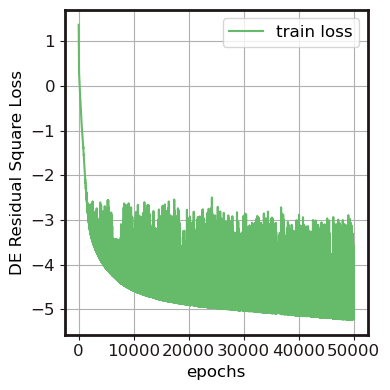

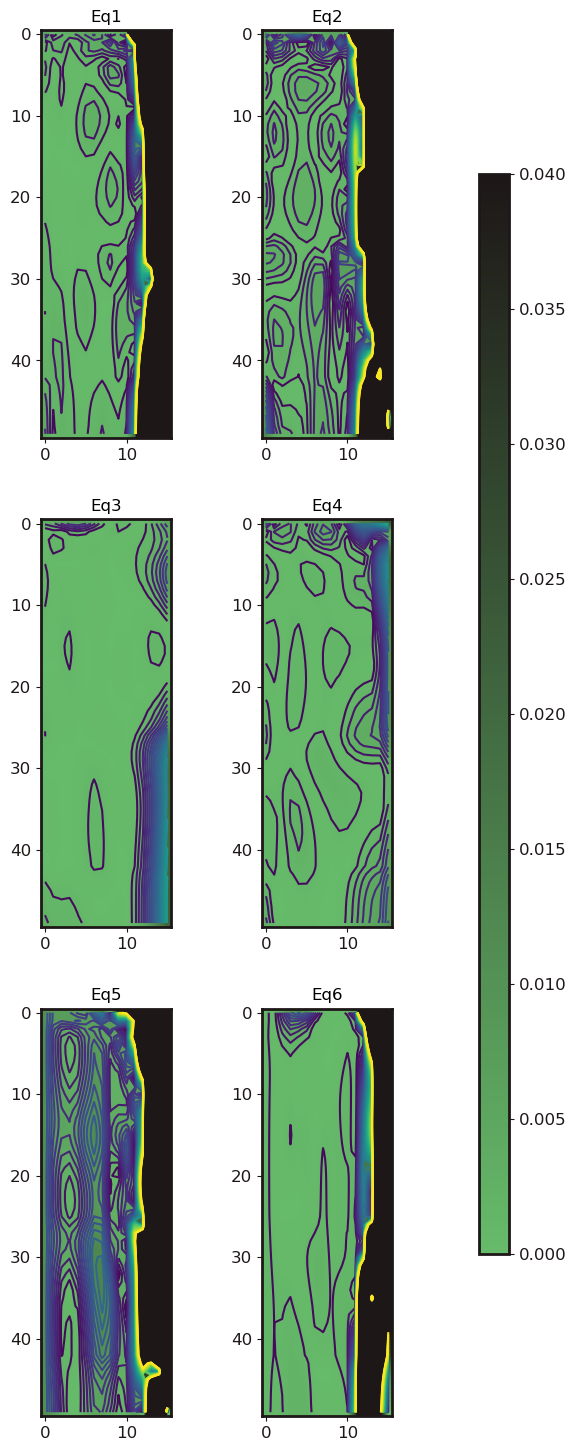

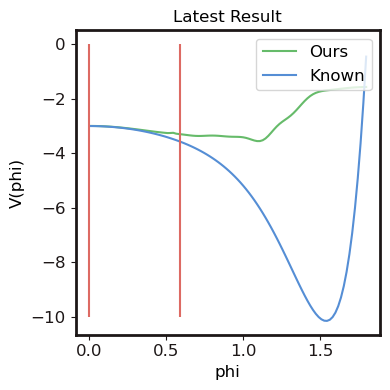

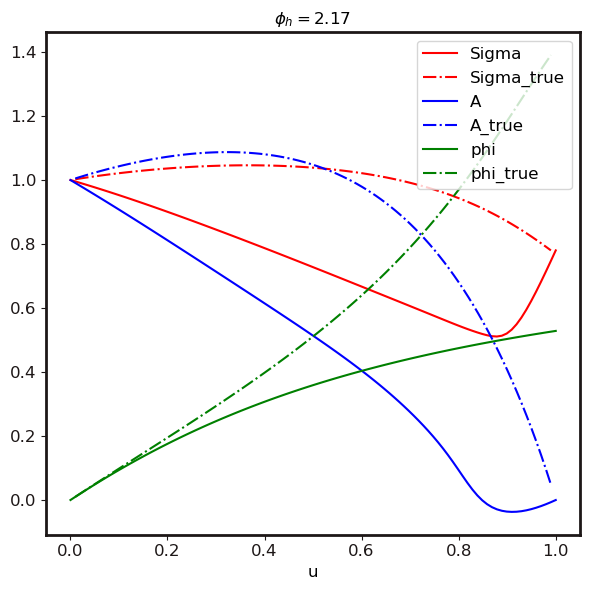

Curriculum changed from 0.7 to 0.98 at epoch 50000
Curriculum: 0.98


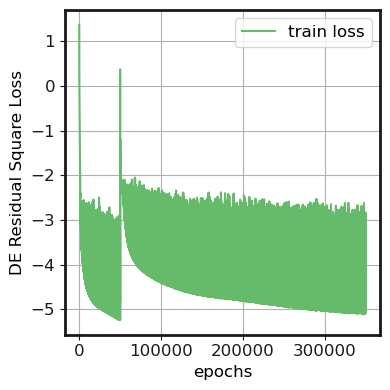

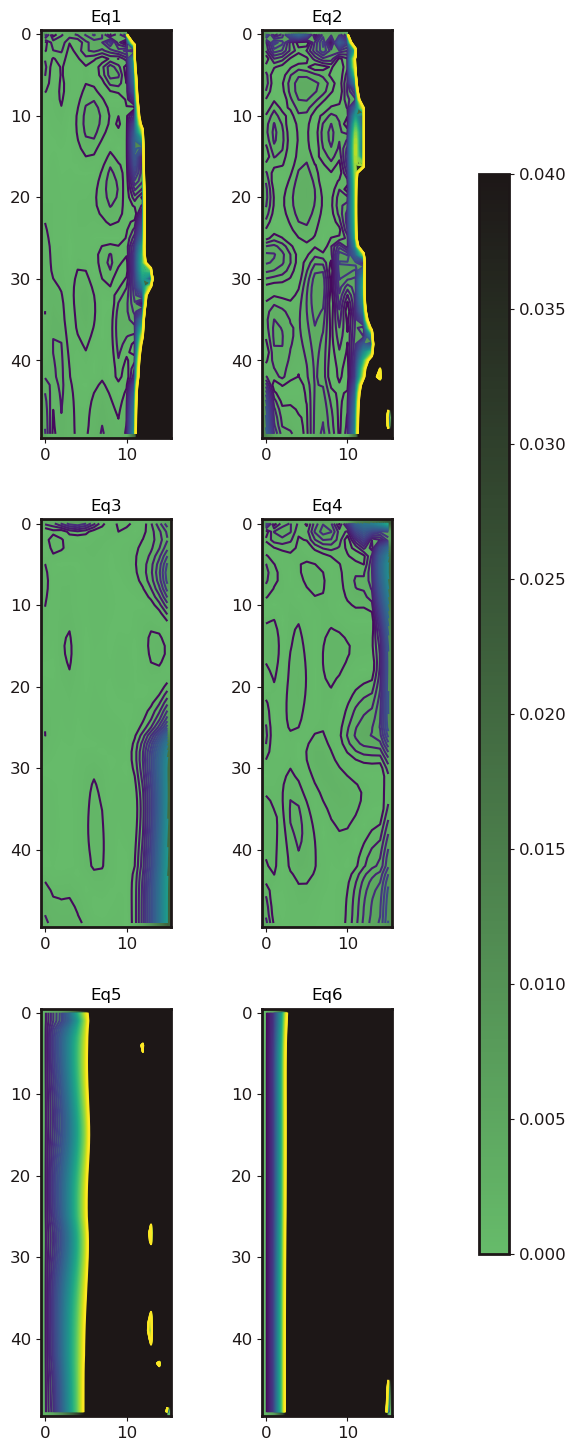

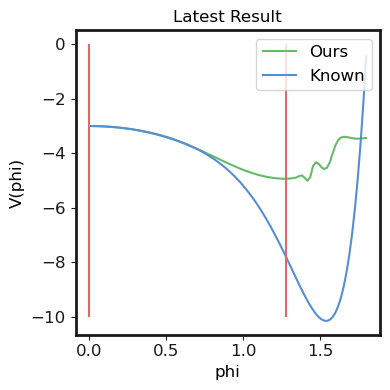

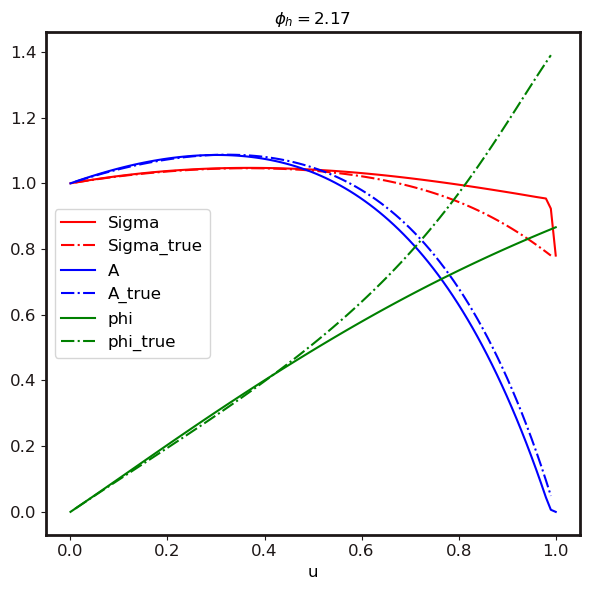

Curriculum changed from 0.98 to 1.0 at epoch 350000
Curriculum: 1.0


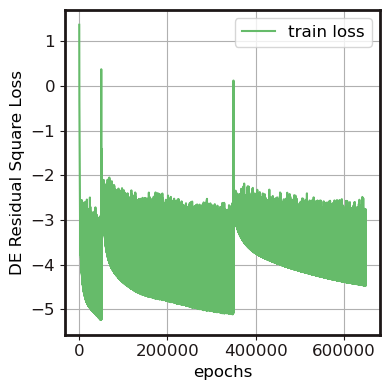

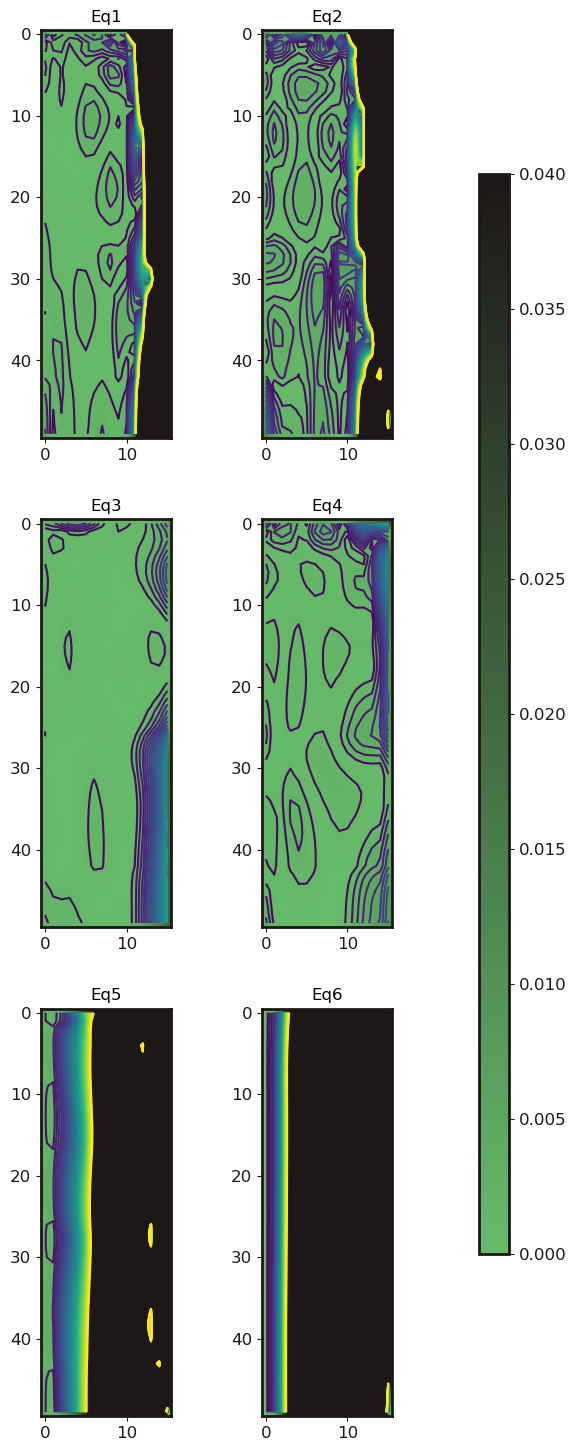

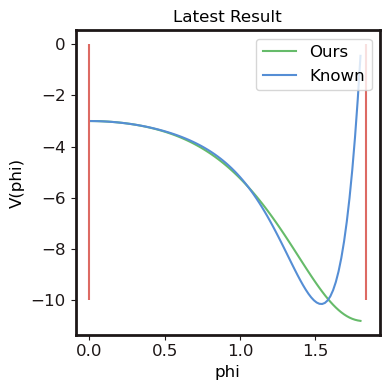

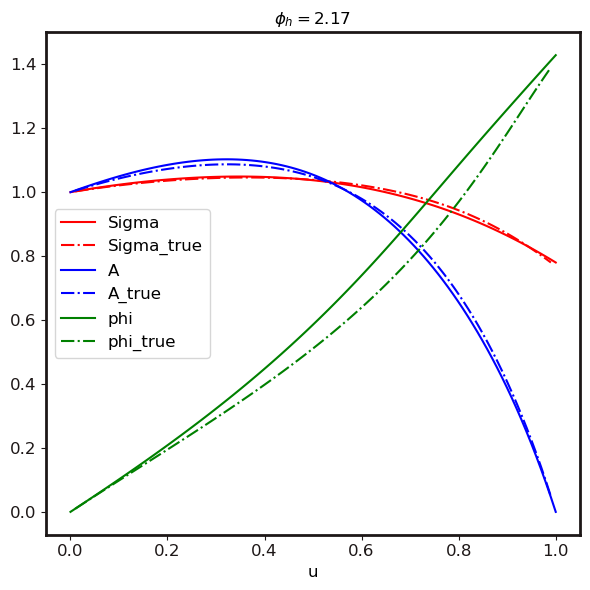

Number of epochs after step learning: 650000


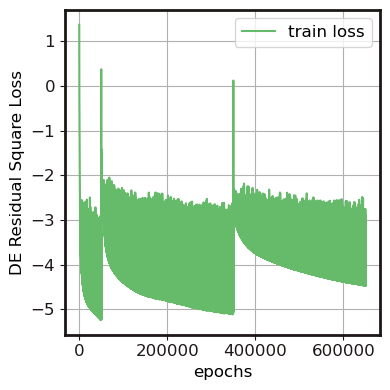

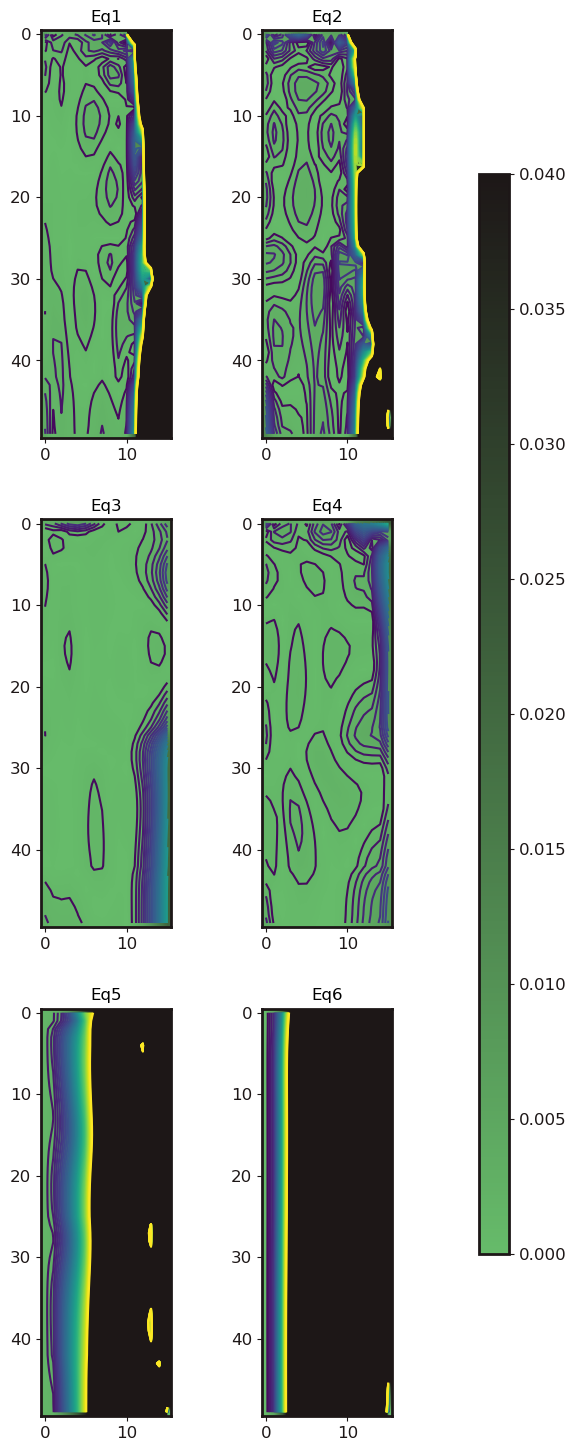

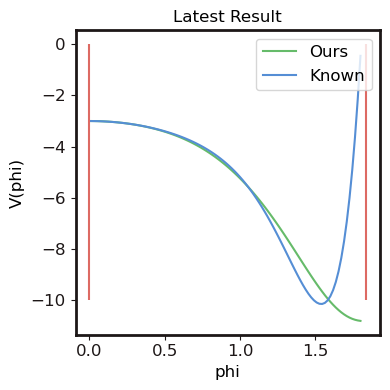

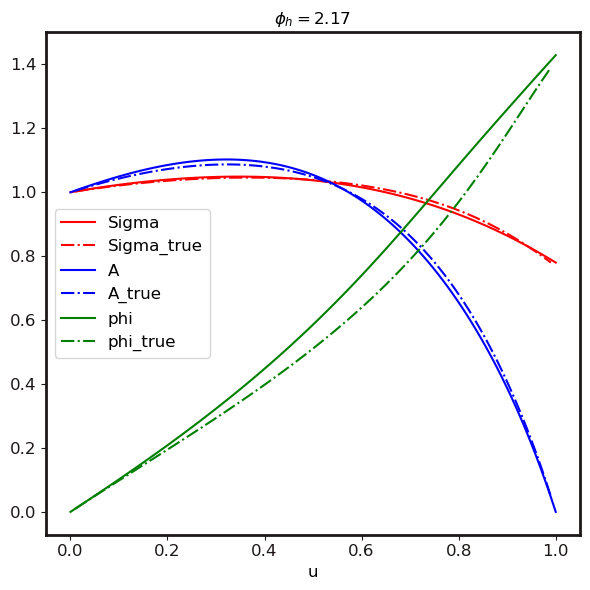

In [10]:
progress_bar = tqdm(dynamic_ncols=True, desc='Epochs', unit='iteration', colour='#0afa9e')
train(starting_epochs=starting_epochs,
      n=n,
      curriculum_list = curriculum_list,
      step_learning_epochs=step_learning_epochs,
      max_iterations_before_change=max_iterations_before_change,
      epochs_after_change=epochs_after_change,
      ending_epochs=ending_epochs,
      ending_epochs_solver=ending_epochs_solver,
      loss_margin=loss_margin,
      verbose=verbose,
      pbar=progress_bar)

In [11]:
c.save_results(f'sl_{len(c.solver.metrics_history["train_loss"])}_epochs')

In [12]:
import dill
dill.__version__

'0.3.7'